In [ ]:
# !mkdir -p ~./kaggle
# !cp kaggle.json ~/.kaggle/


In [ ]:
# !kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [ ]:
# !pip install zipfile36 --upgrade

In [ ]:
# import zipfile
# zipppy = zipfile.ZipFile("/content/covid19-radiography-database.zip", 'r')
# zipppy.extractall('/content')
# zipppy.close()

In [ ]:
import os, shutil, sys, cv2, time

import numpy as np
import pandas as pd
from skimage import transform
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

2024-05-06 17:24:07.061597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 17:24:07.061662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 17:24:07.063175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# libraries = ['os', 'shutil', 'sys', 'opencv-python', 'time', 'numpy', 'pandas', 'scikit-image', 'pillow', 'tqdm', 'matplotlib', 'tensorflow']

# for lib in libraries:
#     !pip install --upgrade {lib}

In [ ]:
np.random.seed(0)

In [ ]:
train_dir = './Train'
val_dir = './Validation'
test_dir = './Test'

for d in [train_dir, val_dir, test_dir]:
    try:
        os.mkdir(d)
    except FileExistsError:
        pass
    except:
        print('Error occurred.')

In [ ]:
train_covid_dir = './Train/COVID'
train_normal_dir = './Train/Normal'

val_covid_dir = './Validation/COVID'
val_normal_dir = './Validation/Normal'

test_covid_dir = './Test/COVID'
test_normal_dir = './Test/Normal'


for d in [train_covid_dir, train_normal_dir, val_covid_dir, val_normal_dir, test_covid_dir, test_normal_dir]:
    try:
        os.mkdir(d)
    except FileExistsError:
        pass
    except:
        print('Error occurred.')

In [ ]:
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1  # 0.7, 0.15, 0.15

base = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset';
for d in os.listdir(base):
    if os.path.isdir(os.path.join(base, d)) and d not in ['Viral Pneumonia', 'Lung_Opacity']:
        files = os.listdir(os.path.join(base, d, 'images'))
        train_files = np.random.choice(files, int(train_ratio*len(files)), replace=False)
        val_files = np.random.choice(list(set(files) - set(train_files)), int(val_ratio*len(files)), replace=False)
        test_files = list(set(files) - set(train_files)- set(val_files))

        print(d, len(files))
        print('Train: {0:d},   Val: {1:d},   Test: {2:d}'.format(len(train_files), len(val_files), len(test_files)))
        for f, root in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
            for file in f:
                try:
                    shutil.copy(os.path.join(base, d, 'images', file), os.path.join(root, d, file))
                except FileExistsError:
                    pass
                except:
                    print('Error occurred.')

Normal 10192
Train: 8153,   Val: 1019,   Test: 1020
COVID 3616
Train: 2892,   Val: 361,   Test: 363


In [ ]:
num_covid_train = len(os.listdir(train_covid_dir))
num_normal_train = len(os.listdir(train_normal_dir))

num_covid_validaition = len(os.listdir(val_covid_dir))
num_normal_validation= len(os.listdir(val_normal_dir))

num_covid_test = len(os.listdir(test_covid_dir))
num_normal_test= len(os.listdir(test_normal_dir))

print("Total Training COVID Images",num_covid_train)
print("Total Training NORMAL Images",num_normal_train)

print("-"*40)
print("Total validation COVID Images",num_covid_validaition)
print("Total validation NORMAL Images",num_normal_validation)

print("-"*40)
print("Total Test COVID Images", num_covid_test)
print("Total Test NORMAL Images",num_normal_test)

print("-"*100)
total_train = num_covid_train+num_normal_train
total_validation = num_covid_validaition+num_normal_validation
total_test = num_covid_test+num_normal_test
print("Total Training Images",total_train)
print("Total Validation Images",total_validation)
print("Total Testing Images",total_test)

Total Training COVID Images 2892
Total Training NORMAL Images 8153
----------------------------------------
Total validation COVID Images 541
Total validation NORMAL Images 1536
----------------------------------------
Total Test COVID Images 543
Total Test NORMAL Images 1537
----------------------------------------------------------------------------------------------------
Total Training Images 11045
Total Validation Images 2077
Total Testing Images 2080


In [ ]:
import tensorflow as tf

IMG_SHAPE = 224
dropout_dense = 0.5

pre_trained_model = tf.keras.applications.VGG16(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

print(len(pre_trained_model.layers))

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output.shape)  # Access output tensor and then get its shape
last_output = last_layer.output

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(2, activation="softmax")
])

model.summary()


19
last layer output shape: (None, 7, 7, 512)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'


In [ ]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', tf.metrics.Precision(), tf.metrics.Recall()])
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32  # 50


image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, #10
                                     width_shift_range=0.1, #0.1
                                     height_shift_range=0.1, #0.1
                                     shear_range = 0.1, #0
                                     zoom_range = 0.1, #0.1
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),
                                                    class_mode  = "categorical")

Found 11045 images belonging to 2 classes.


In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=50,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 2077 images belonging to 2 classes.
Found 2080 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics

# Define your model architecture here
# model = tf.keras.Model(pre_trained_model.input, x)

# Initialize the optimizer without the 'decay' parameter
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', metrics.Precision(), metrics.Recall()])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
from tensorflow.keras.optimizers import Adam

epochs = 50
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history_mod = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1,
                        steps_per_epoch=150, validation_steps=11)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 647ms/step - accuracy: 0.7431 - loss: 0.2520 - val_accuracy: 0.7585 - val_loss: 0.2415
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 602ms/step - accuracy: 0.7231 - loss: 0.2769 - val_accuracy: 0.7330 - val_loss: 0.2670
Epoch 3/50
 46/150 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.7513 - loss: 0.2487

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.7447 - loss: 0.2553 - val_accuracy: 0.7301 - val_loss: 0.2699
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 93s 602ms/step - accuracy: 0.7332 - loss: 0.2668 - val_accuracy: 0.7642 - val_loss: 0.2358
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 604ms/step - accuracy: 0.7363 - loss: 0.2637 - val_accuracy: 0.7443 - val_loss: 0.2557
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.7393 - loss: 0.2607 - val_accuracy: 0.7035 - val_loss: 0.2965
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 94s 605ms/step - accuracy: 0.7362 - loss: 0.2638 - val_accuracy: 0.7557 - val_loss: 0.2443
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 604ms/step - accuracy: 0.7398 - loss: 0.2602 - val_accuracy: 0.7330 - val_loss: 0.2670
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.7496 - loss: 0.2504 - val_accuracy: 0.7273 - val_loss: 0.2727
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 93s 604ms/step - accuracy: 0.7400 - loss: 0.2600 - va

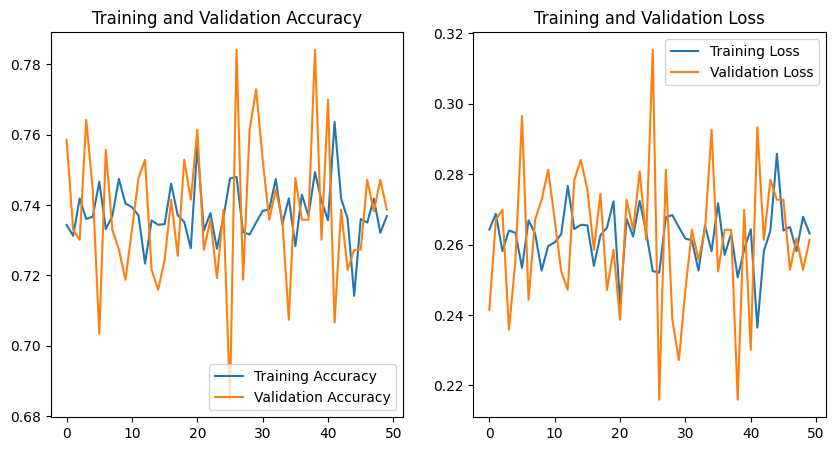

In [ ]:
acc = history_mod.history['accuracy']
val_acc = history_mod.history['val_accuracy']

loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']

epochs_range = range(len(loss))


plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('2_VGG16_Accuracy_loss.png')
plt.savefig('2_VGG16_Accuracy_loss.pdf', dpi=200)
plt.show()